# Jupyter notebook accompany synaptic nanocolumn analysis for multi-ExR manuscript

Last edited by M. Schroeder on 7.17.23

In [1]:
#import relevant packages
import os
import numpy as np
#from skimage import io
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import robust_scale
from sklearn.cluster import KMeans
import scanpy as sc
import anndata
#import leidenalg
#import igraph as ig
from scipy.stats import ttest_ind

In [2]:
def unique(list1): 
    # insert the list to the set 
    list_set = set(list1) 
    # convert the set to the list 
    unique_list = (list(list_set))
    return unique_list

In [3]:
filenames = os.listdir()
csvs = [filename for filename in filenames if filename.endswith('csv') and 'all' in filename]

In [4]:
csvs

[]

In [5]:
os.getcwd()

'/Users/margaret/Dropbox (MIT)/mExR_analysis/Scripts/Python'

In [6]:
parentdir = '/Users/margaret/Dropbox (MIT)/mExR_analysis/SmallData/2023.03_synapses/nanocolumn_data/'

In [7]:
os.listdir(parentdir)

['AutoCorrelation_S1ROI2.txt',
 'S2ROI2_AtoB_Enrichment_refAlign.txt',
 'S1ROI4_AtoB_Enrichment_refAlign.txt',
 'AutoCorrelation_S1ROI3.txt',
 'AutoCorrelation_S1ROI1.txt',
 'AutoCorrelation_S1ROI4.txt',
 '.DS_Store',
 'S2ROI1_AtoB_Enrichment_refAlign.txt',
 'nanocolumn_rois_cutoff.csv',
 'AutoCorrelation_S2ROI1.txt',
 'S1ROI1_AtoB_Enrichment_refAlign.txt',
 'AutoCorrelation_S2ROI2.txt',
 'AutoCorrelation_S2ROI3.txt',
 'enrichment_index.csv',
 'S1ROI2_AtoB_Enrichment_refAlign.txt',
 'enrichment_index_pairwise_noxyzshift.csv',
 'S2ROI4_AtoB_Enrichment_refAlign.txt',
 'AutoCorrelation_S2ROI4.txt',
 'S1ROI3_AtoB_Enrichment_refAlign.txt',
 'autocorrelation_curve_all_confs.png',
 'nanocolumn_rois_cutoff_v2.csv',
 'nanocolumn_rois_cutoff_v2.xlsx',
 'nanocolumn_rois_cutoff.xlsx',
 'autocorrelation_curve_all.png',
 'S2ROI3_AtoB_Enrichment_refAlign.txt']

Define dictionary of channels

In [8]:
channel_dict = {
    1: "SynGAP",2: "NR1",
    3: "RIM1",4: "Gephyrin",
    5: "GluA4",6: "IRSp53",
    7: "GluA1",8: "NR2B",
    9: "Homer1",10: "CamKIIa",
    11: "Shank3",
    12: "Bassoon",
    13: "Erbb4", 14: "Stargazin",
    15: "Elfn1",
    16: "PSD95", 17: "Cav2.1",
    18: "Vglut1",19:"GluA2",
    20:"GluA3"
}

In [9]:
len(channel_dict)

20

## 1) Load and analyze nanoclumn auto-correlation data

In [10]:
auto_data1 = pd.read_csv(parentdir + 'AutoCorrelation_S1ROI1.txt',sep='\t',header=None)
auto_data2 = pd.read_csv(parentdir + 'AutoCorrelation_S1ROI2.txt',sep='\t',header=None)
auto_data3 = pd.read_csv(parentdir + 'AutoCorrelation_S1ROI3.txt',sep='\t',header=None)
auto_data4 = pd.read_csv(parentdir + 'AutoCorrelation_S1ROI4.txt',sep='\t',header=None)
auto_data5 = pd.read_csv(parentdir + 'AutoCorrelation_S2ROI1.txt',sep='\t',header=None)
auto_data6 = pd.read_csv(parentdir + 'AutoCorrelation_S2ROI2.txt',sep='\t',header=None)
auto_data7 = pd.read_csv(parentdir + 'AutoCorrelation_S2ROI3.txt',sep='\t',header=None)
auto_data8 = pd.read_csv(parentdir + 'AutoCorrelation_S2ROI4.txt',sep='\t',header=None)

In [11]:
auto_data2[0] = [2.0]*len(auto_data2)
auto_data3[0] = [3.0]*len(auto_data3)
auto_data4[0] = [4.0]*len(auto_data4)
auto_data5[0] = [5.0]*len(auto_data5)
auto_data6[0] = [6.0]*len(auto_data6)
auto_data7[0] = [7.0]*len(auto_data7)
auto_data8[0] = [8.0]*len(auto_data8)

In [12]:
columns = ['ROI_no','synapse_no','ch_1','x_shift','y_shift','z_shift','avg_int_ch1','avg_int_ch2',
          '1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22']

In [13]:
auto_data = pd.concat((auto_data1,auto_data2,auto_data3,auto_data4,auto_data5,auto_data6,auto_data7,auto_data8), axis=0)
auto_data.columns = columns

In [14]:
auto_data = auto_data.astype(float)

In [15]:
auto_data.dropna(how='all',inplace=True,axis=1)

In [16]:
auto_data['synID'] = auto_data['ROI_no'].astype(str) + "-" + auto_data['synapse_no'].astype(str)

In [17]:
auto_data

,ROI_no,synapse_no,ch_1,x_shift,y_shift,z_shift,avg_int_ch1,avg_int_ch2,1,2,...,13,14,15,16,17,18,19,20,21,synID
0,1.0,1.0,1.0,0.0,0.0,0.0,1.511661,1.511661,1.380175,1.386227,...,1.160998,1.160276,1.154308,1.148939,1.142603,1.138496,1.133612,1.130673,1.125329,1.0-1.0
1,1.0,1.0,2.0,0.0,0.0,0.0,1.057434,1.057434,1.139821,1.180259,...,1.084363,1.091237,1.096980,1.098670,1.100549,1.102934,1.099622,1.093724,NaN,1.0-1.0
2,1.0,1.0,3.0,0.0,0.0,0.0,1.620675,1.620675,1.440722,1.468394,...,1.333431,1.320553,1.298656,1.278250,1.254411,1.235246,1.216750,1.210786,1.202443,1.0-1.0
3,1.0,1.0,4.0,0.0,0.0,0.0,1.397040,1.397040,1.454520,1.492621,...,1.510771,1.483736,1.448079,1.400245,NaN,NaN,NaN,NaN,NaN,1.0-1.0
4,1.0,1.0,5.0,0.0,0.0,0.0,1.769636,1.769636,1.482911,1.517245,...,1.222250,1.216396,1.176090,1.147416,1.097748,1.040066,0.969519,0.909046,NaN,1.0-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,8.0,15.0,16.0,0.0,0.0,0.0,1.417466,1.417466,1.424064,1.440388,...,1.224801,1.226250,1.238208,1.246840,1.233562,1.214472,1.196298,1.191976,1.179299,8.0-15.0
296,8.0,15.0,17.0,0.0,0.0,0.0,1.425921,1.425921,1.470306,1.496406,...,1.429453,1.441442,1.440263,1.436146,1.420937,NaN,NaN,NaN,NaN,8.0-15.0
297,8.0,15.0,18.0,0.0,0.0,0.0,1.386759,1.386759,1.466756,1.488745,...,1.278822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0-15.0
298,8.0,15.0,19.0,0.0,0.0,0.0,1.459251,1.459251,1.436603,1.464328,...,1.157608,1.175261,1.194133,1.199216,1.185127,NaN,NaN,NaN,NaN,8.0-15.0


In [18]:
auto_data['synID'].value_counts()

1.0-1.0     20
1.0-2.0     20
6.0-12.0    20
6.0-11.0    20
6.0-10.0    20
            ..
3.0-5.0     20
3.0-4.0     20
3.0-3.0     20
3.0-2.0     20
8.0-15.0    20
Name: synID, Length: 96, dtype: int64

In [19]:
len(unique(auto_data['synID']))

96

### Plot proteins separately

In [20]:
nproteins = len(channel_dict)

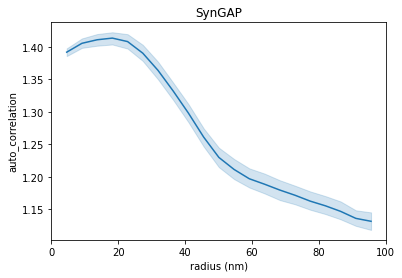

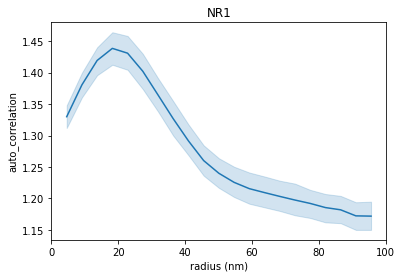

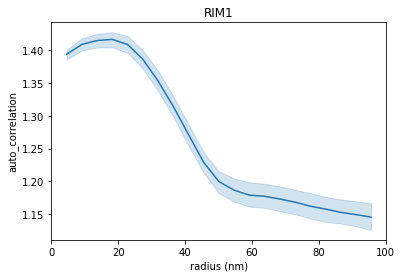

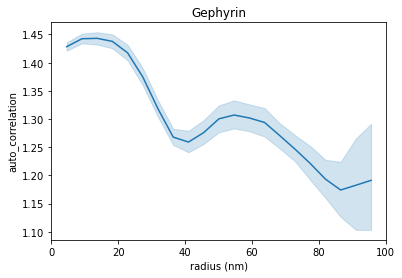

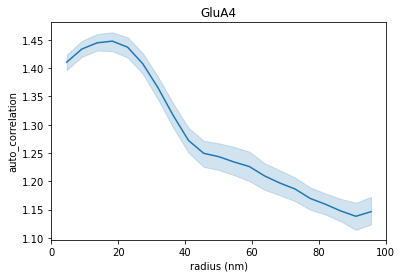

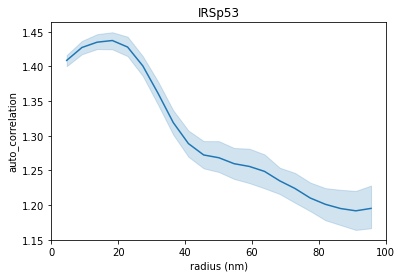

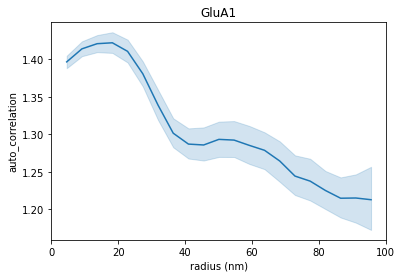

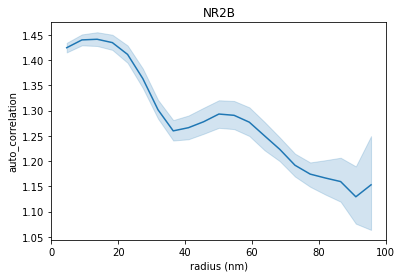

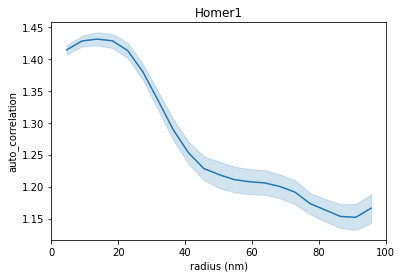

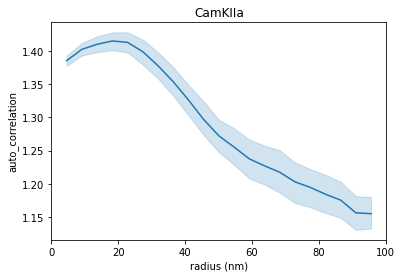

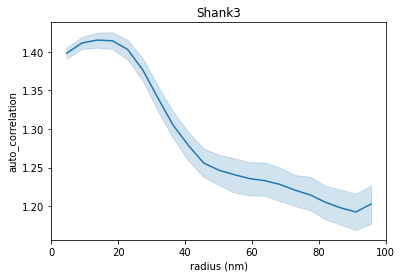

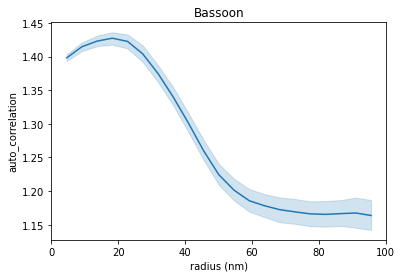

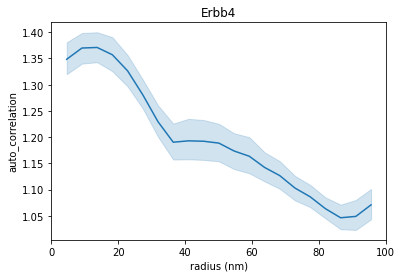

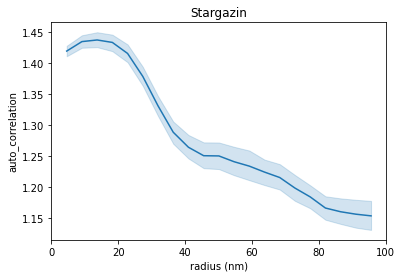

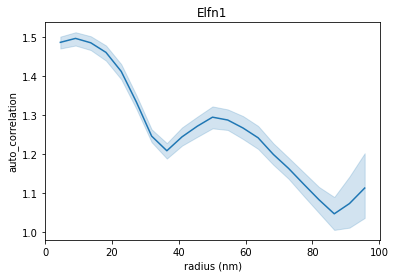

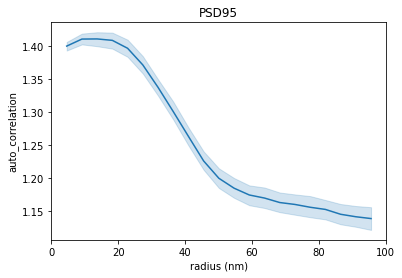

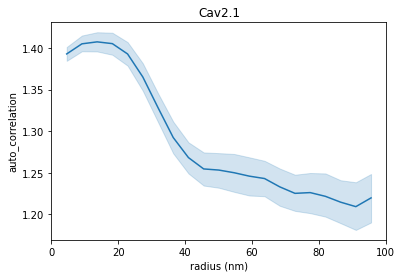

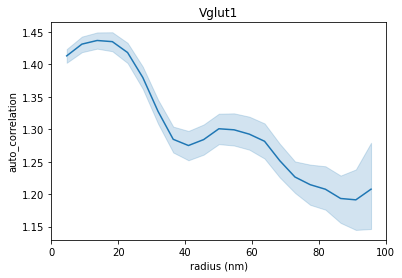

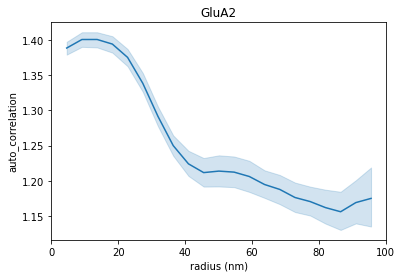

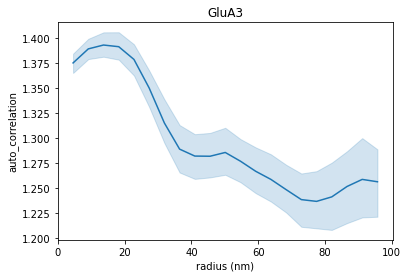

In [21]:
count = 0
for ch1 in range(1,nproteins+1):
    auto_datasub = auto_data[(auto_data['ch_1']==ch1)]
    auto_data_toplot = auto_datasub.drop(['ROI_no','synapse_no','ch_1','x_shift','y_shift','z_shift',
                               'avg_int_ch1','avg_int_ch2'],axis=1)
    auto_data_toplot.index=auto_data_toplot['synID']
    auto_data_toplot = auto_data_toplot.drop(['synID'],axis=1)
    melted = auto_data_toplot.melt(ignore_index=False)
    melted.rename(columns={"variable": "radius (pixels)", "value": "auto_correlation"},inplace=True)
    melted['radius (pixels)'] = melted['radius (pixels)'].astype(int)
    melted['auto_correlation'] = melted['auto_correlation'].astype(float)
    melted['radius (nm)'] = melted['radius (pixels)'] * (82/18)
    melted.reset_index(inplace=True)

    protein1 = channel_dict[ch1]

    fig,ax = plt.subplots(1)
    melted['protein'] = [protein1]*len(melted)
    ax = sns.lineplot(data=melted,x='radius (nm)',y='auto_correlation')
    ax.set_title(protein1)

    if count == 0:
        allauto_data = melted
        allauto_data['protein'] = [protein1]*len(melted)
    else:
        toadd = melted
        toadd['protein']= [protein1]*len(melted)
        allauto_data = pd.concat((allauto_data,toadd),axis=0)
    count = count + 1

In [22]:
allauto_data

,synID,radius (pixels),auto_correlation,radius (nm),protein
0,1.0-1.0,1,1.380175,4.555556,SynGAP
1,1.0-2.0,1,1.399631,4.555556,SynGAP
2,1.0-3.0,1,1.461826,4.555556,SynGAP
3,1.0-4.0,1,1.383210,4.555556,SynGAP
4,1.0-5.0,1,1.357933,4.555556,SynGAP
...,...,...,...,...,...
2011,8.0-11.0,21,NaN,95.666667,GluA3
2012,8.0-12.0,21,NaN,95.666667,GluA3
2013,8.0-13.0,21,NaN,95.666667,GluA3
2014,8.0-14.0,21,1.279335,95.666667,GluA3


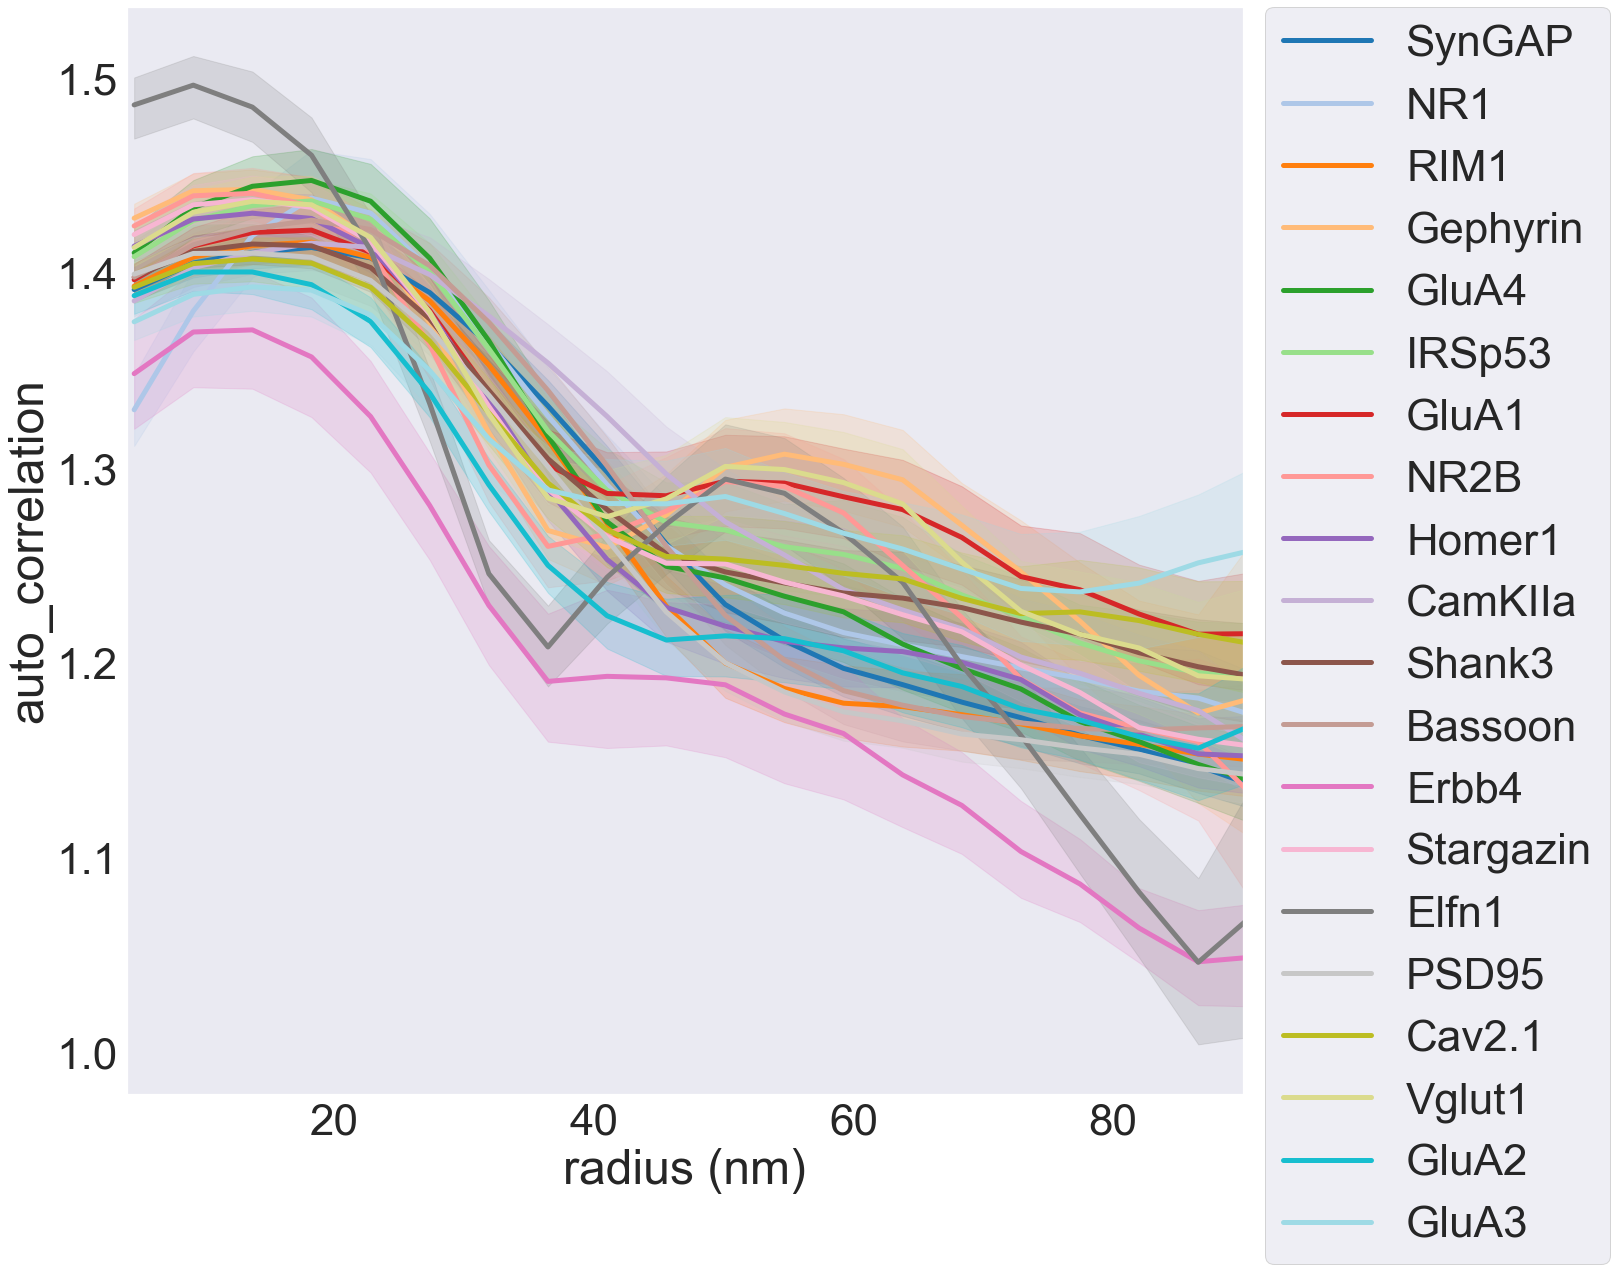

In [23]:
plt.figure(figsize=(20, 20))
sns.set(font_scale=4)
ax = sns.lineplot(data=allauto_data.reset_index(), x='radius (nm)', y='auto_correlation',
                  hue='protein', palette='tab20', legend='brief', linewidth=5)
legend = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
for line in legend.get_lines():
    line.set_linewidth(5)
ax.set_xlim(left=4, right=90)
ax.grid(False)
plt.savefig(parentdir + 'autocorrelation_curve_all.png', dpi=300, transparent=True, bbox_inches='tight')

## Plot only ROIs we are confident about

In [24]:
os.listdir(parentdir)

['AutoCorrelation_S1ROI2.txt',
 'S2ROI2_AtoB_Enrichment_refAlign.txt',
 'S1ROI4_AtoB_Enrichment_refAlign.txt',
 'AutoCorrelation_S1ROI3.txt',
 'AutoCorrelation_S1ROI1.txt',
 'AutoCorrelation_S1ROI4.txt',
 '.DS_Store',
 'S2ROI1_AtoB_Enrichment_refAlign.txt',
 'nanocolumn_rois_cutoff.csv',
 'AutoCorrelation_S2ROI1.txt',
 'S1ROI1_AtoB_Enrichment_refAlign.txt',
 'AutoCorrelation_S2ROI2.txt',
 'AutoCorrelation_S2ROI3.txt',
 'enrichment_index.csv',
 'S1ROI2_AtoB_Enrichment_refAlign.txt',
 'enrichment_index_pairwise_noxyzshift.csv',
 'S2ROI4_AtoB_Enrichment_refAlign.txt',
 'AutoCorrelation_S2ROI4.txt',
 'S1ROI3_AtoB_Enrichment_refAlign.txt',
 'autocorrelation_curve_all_confs.png',
 'nanocolumn_rois_cutoff_v2.csv',
 'nanocolumn_rois_cutoff_v2.xlsx',
 'nanocolumn_rois_cutoff.xlsx',
 'autocorrelation_curve_all.png',
 'S2ROI3_AtoB_Enrichment_refAlign.txt']

In [25]:
cutoff_inds = pd.read_csv(parentdir + 'nanocolumn_rois_cutoff_v2.csv')

In [26]:
cutoff_inds.head(5)

,ROI,ROIno,filename_no,synapse_no,confident
0,S1ROI1,1,synapse0,1,yes
1,S1ROI1,1,synapse1,2,yes
2,S1ROI1,1,synapse2,3,yes
3,S1ROI1,1,synapse3,4,yes
4,S1ROI1,1,synapse4,5,yes


In [27]:
cutoff_inds['confident'].value_counts()

yes    80
no     16
Name: confident, dtype: int64

In [28]:
keeper_inds = cutoff_inds[cutoff_inds['confident']=='yes']

In [29]:
auto_data.reset_index(inplace=True)

In [30]:
keeper_inds

,ROI,ROIno,filename_no,synapse_no,confident
0,S1ROI1,1,synapse0,1,yes
1,S1ROI1,1,synapse1,2,yes
2,S1ROI1,1,synapse2,3,yes
3,S1ROI1,1,synapse3,4,yes
4,S1ROI1,1,synapse4,5,yes
...,...,...,...,...,...
89,S2ROI4,8,synapse8,90,yes
90,S2ROI4,8,synapse9,91,yes
91,S2ROI4,8,synapse10,92,yes
92,S2ROI4,8,synapse11,93,yes


In [31]:
inds_tokeep = []
for idx,row in keeper_inds.iterrows():
    roino = int(row['ROIno'])
    synapseno = int(row['synapse_no'])
    inds_tokeep.extend(auto_data[auto_data['synapse_no']==synapseno].index)

In [32]:
synapseno

94

In [33]:
len(inds_tokeep)

1700

In [34]:
auto_data=auto_data.loc[inds_tokeep,:]

In [35]:
auto_data

,index,ROI_no,synapse_no,ch_1,x_shift,y_shift,z_shift,avg_int_ch1,avg_int_ch2,1,...,13,14,15,16,17,18,19,20,21,synID
0,0,1.0,1.0,1.0,0.0,0.0,0.0,1.511661,1.511661,1.380175,...,1.160998,1.160276,1.154308,1.148939,1.142603,1.138496,1.133612,1.130673,1.125329,1.0-1.0
1,1,1.0,1.0,2.0,0.0,0.0,0.0,1.057434,1.057434,1.139821,...,1.084363,1.091237,1.096980,1.098670,1.100549,1.102934,1.099622,1.093724,NaN,1.0-1.0
2,2,1.0,1.0,3.0,0.0,0.0,0.0,1.620675,1.620675,1.440722,...,1.333431,1.320553,1.298656,1.278250,1.254411,1.235246,1.216750,1.210786,1.202443,1.0-1.0
3,3,1.0,1.0,4.0,0.0,0.0,0.0,1.397040,1.397040,1.454520,...,1.510771,1.483736,1.448079,1.400245,NaN,NaN,NaN,NaN,NaN,1.0-1.0
4,4,1.0,1.0,5.0,0.0,0.0,0.0,1.769636,1.769636,1.482911,...,1.222250,1.216396,1.176090,1.147416,1.097748,1.040066,0.969519,0.909046,NaN,1.0-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,295,8.0,15.0,16.0,0.0,0.0,0.0,1.417466,1.417466,1.424064,...,1.224801,1.226250,1.238208,1.246840,1.233562,1.214472,1.196298,1.191976,1.179299,8.0-15.0
1916,296,8.0,15.0,17.0,0.0,0.0,0.0,1.425921,1.425921,1.470306,...,1.429453,1.441442,1.440263,1.436146,1.420937,NaN,NaN,NaN,NaN,8.0-15.0
1917,297,8.0,15.0,18.0,0.0,0.0,0.0,1.386759,1.386759,1.466756,...,1.278822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0-15.0
1918,298,8.0,15.0,19.0,0.0,0.0,0.0,1.459251,1.459251,1.436603,...,1.157608,1.175261,1.194133,1.199216,1.185127,NaN,NaN,NaN,NaN,8.0-15.0


In [36]:
auto_data['synID']

0        1.0-1.0
1        1.0-1.0
2        1.0-1.0
3        1.0-1.0
4        1.0-1.0
          ...   
1915    8.0-15.0
1916    8.0-15.0
1917    8.0-15.0
1918    8.0-15.0
1919    8.0-15.0
Name: synID, Length: 1700, dtype: object

In [37]:
del auto_data['index']

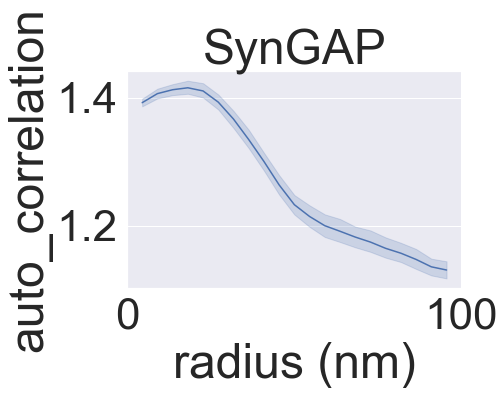

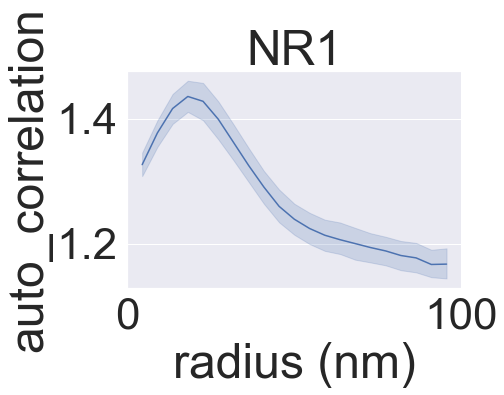

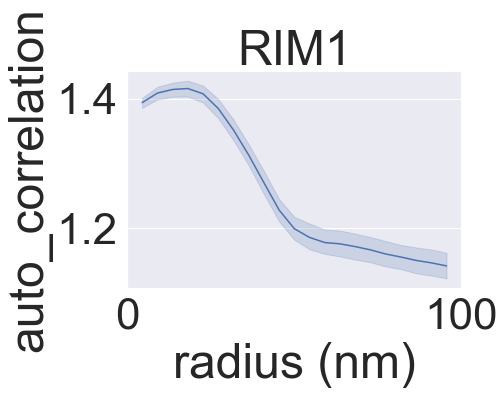

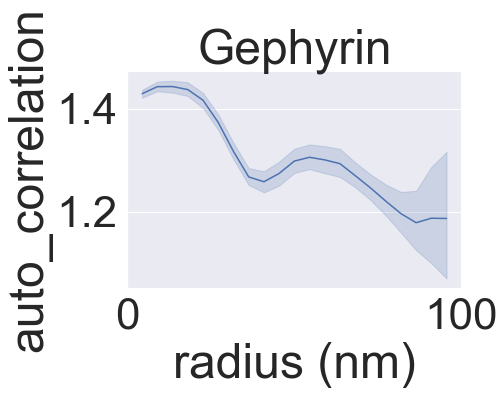

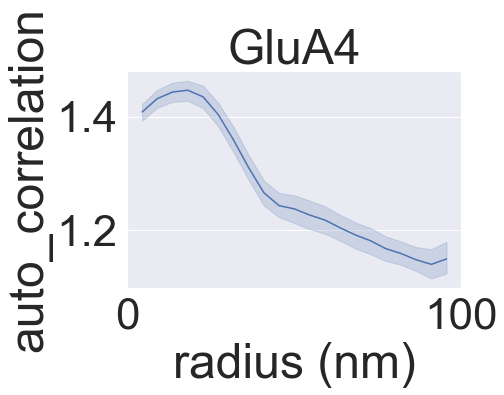

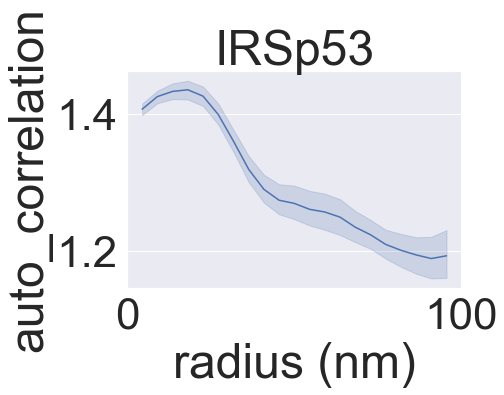

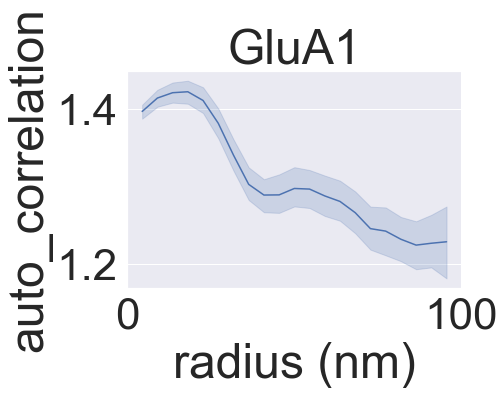

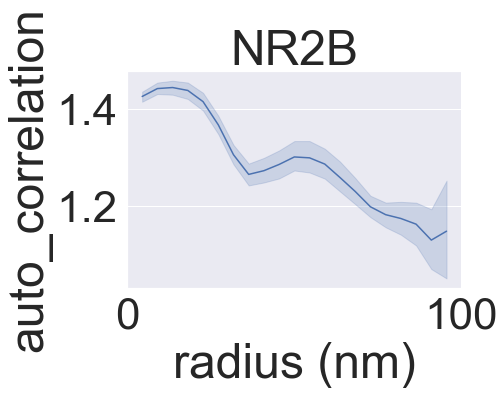

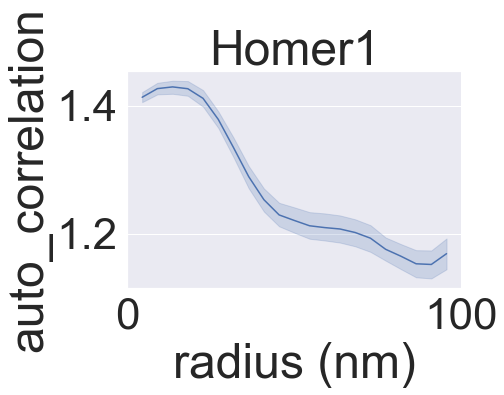

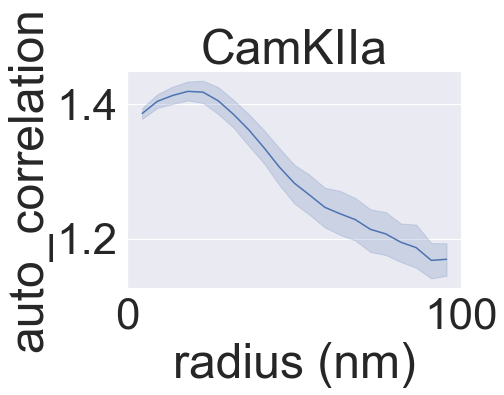

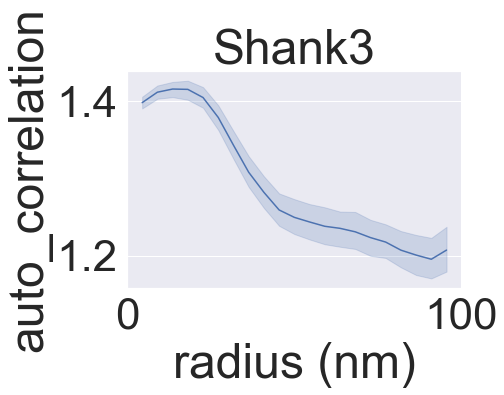

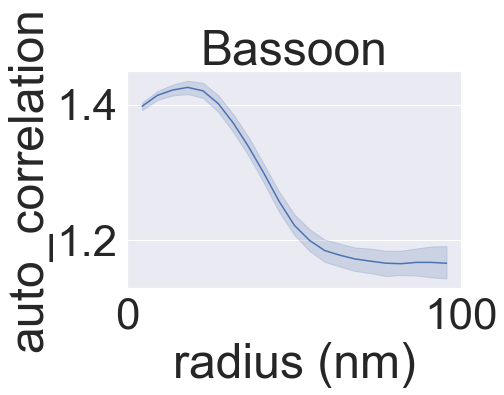

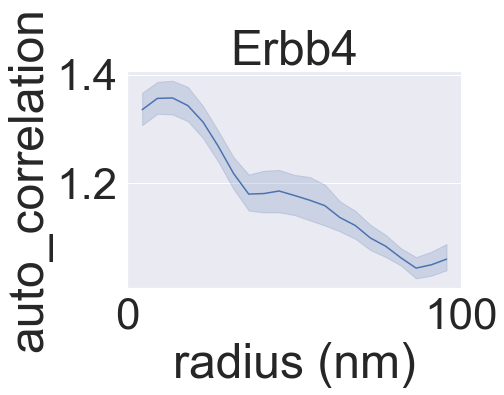

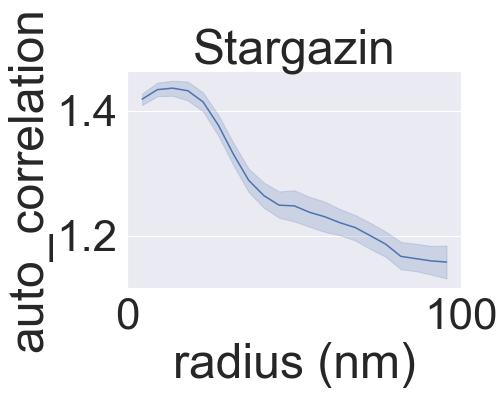

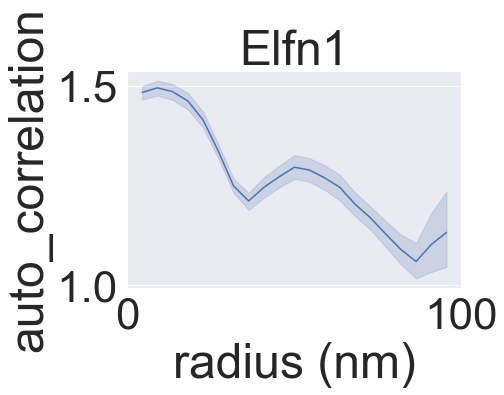

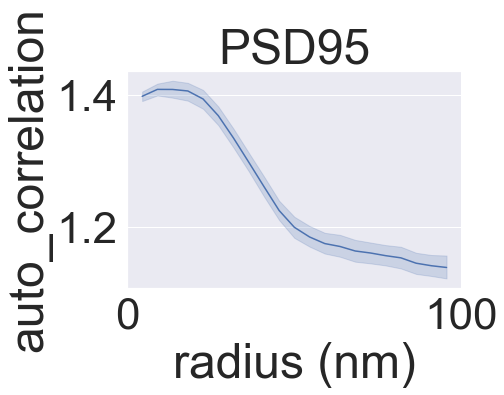

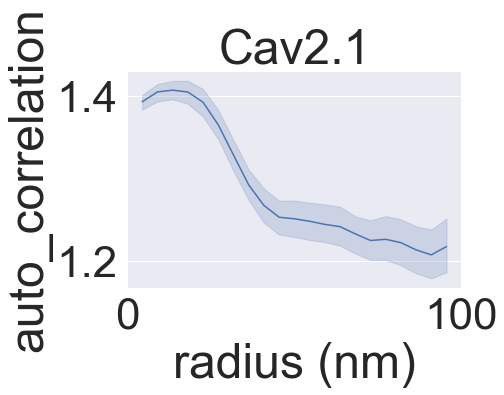

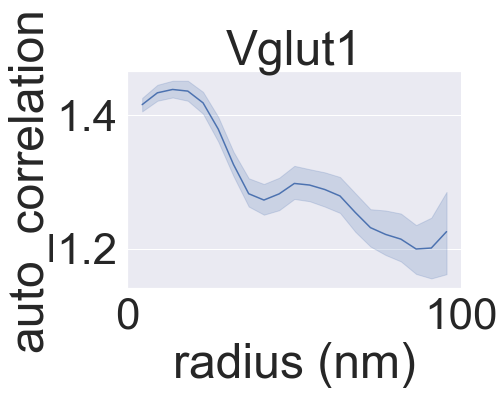

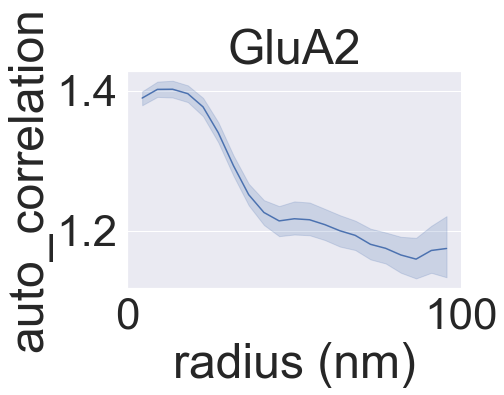

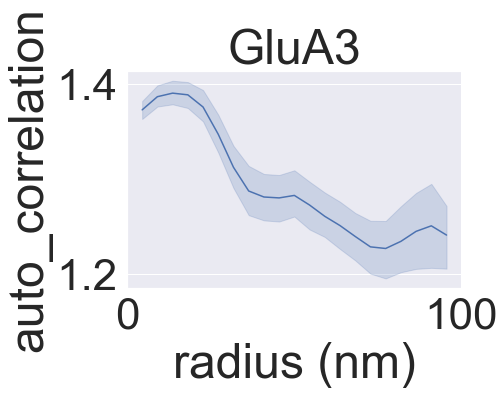

In [38]:
count = 0
for ch1 in range(1,nproteins+1):
    auto_datasub = auto_data[(auto_data['ch_1']==ch1)]
    auto_data_toplot = auto_datasub.drop(['ROI_no','synapse_no','ch_1','x_shift','y_shift','z_shift',
                               'avg_int_ch1','avg_int_ch2'],axis=1)
    auto_data_toplot.index=auto_data_toplot['synID']
    auto_data_toplot = auto_data_toplot.drop(['synID'],axis=1)
    melted = auto_data_toplot.melt(ignore_index=False)
    melted.rename(columns={"variable": "radius (pixels)", "value": "auto_correlation"},inplace=True)
    melted['radius (pixels)'] = melted['radius (pixels)'].astype(int)
    melted['auto_correlation'] = melted['auto_correlation'].astype(float)
    melted['radius (nm)'] = melted['radius (pixels)'] * (82/18)
    melted.reset_index(inplace=True)

    protein1 = channel_dict[ch1]

    fig,ax = plt.subplots(1)
    melted['protein'] = [protein1]*len(melted)
    ax = sns.lineplot(data=melted,x='radius (nm)',y='auto_correlation')
    ax.set_title(protein1)

    if count == 0:
        allauto_data = melted
        allauto_data['protein'] = [protein1]*len(melted)
    else:
        toadd = melted
        toadd['protein']= [protein1]*len(melted)
        allauto_data = pd.concat((allauto_data,toadd),axis=0)
    count = count + 1

In [39]:
len(unique(allauto_data['synID']))

85

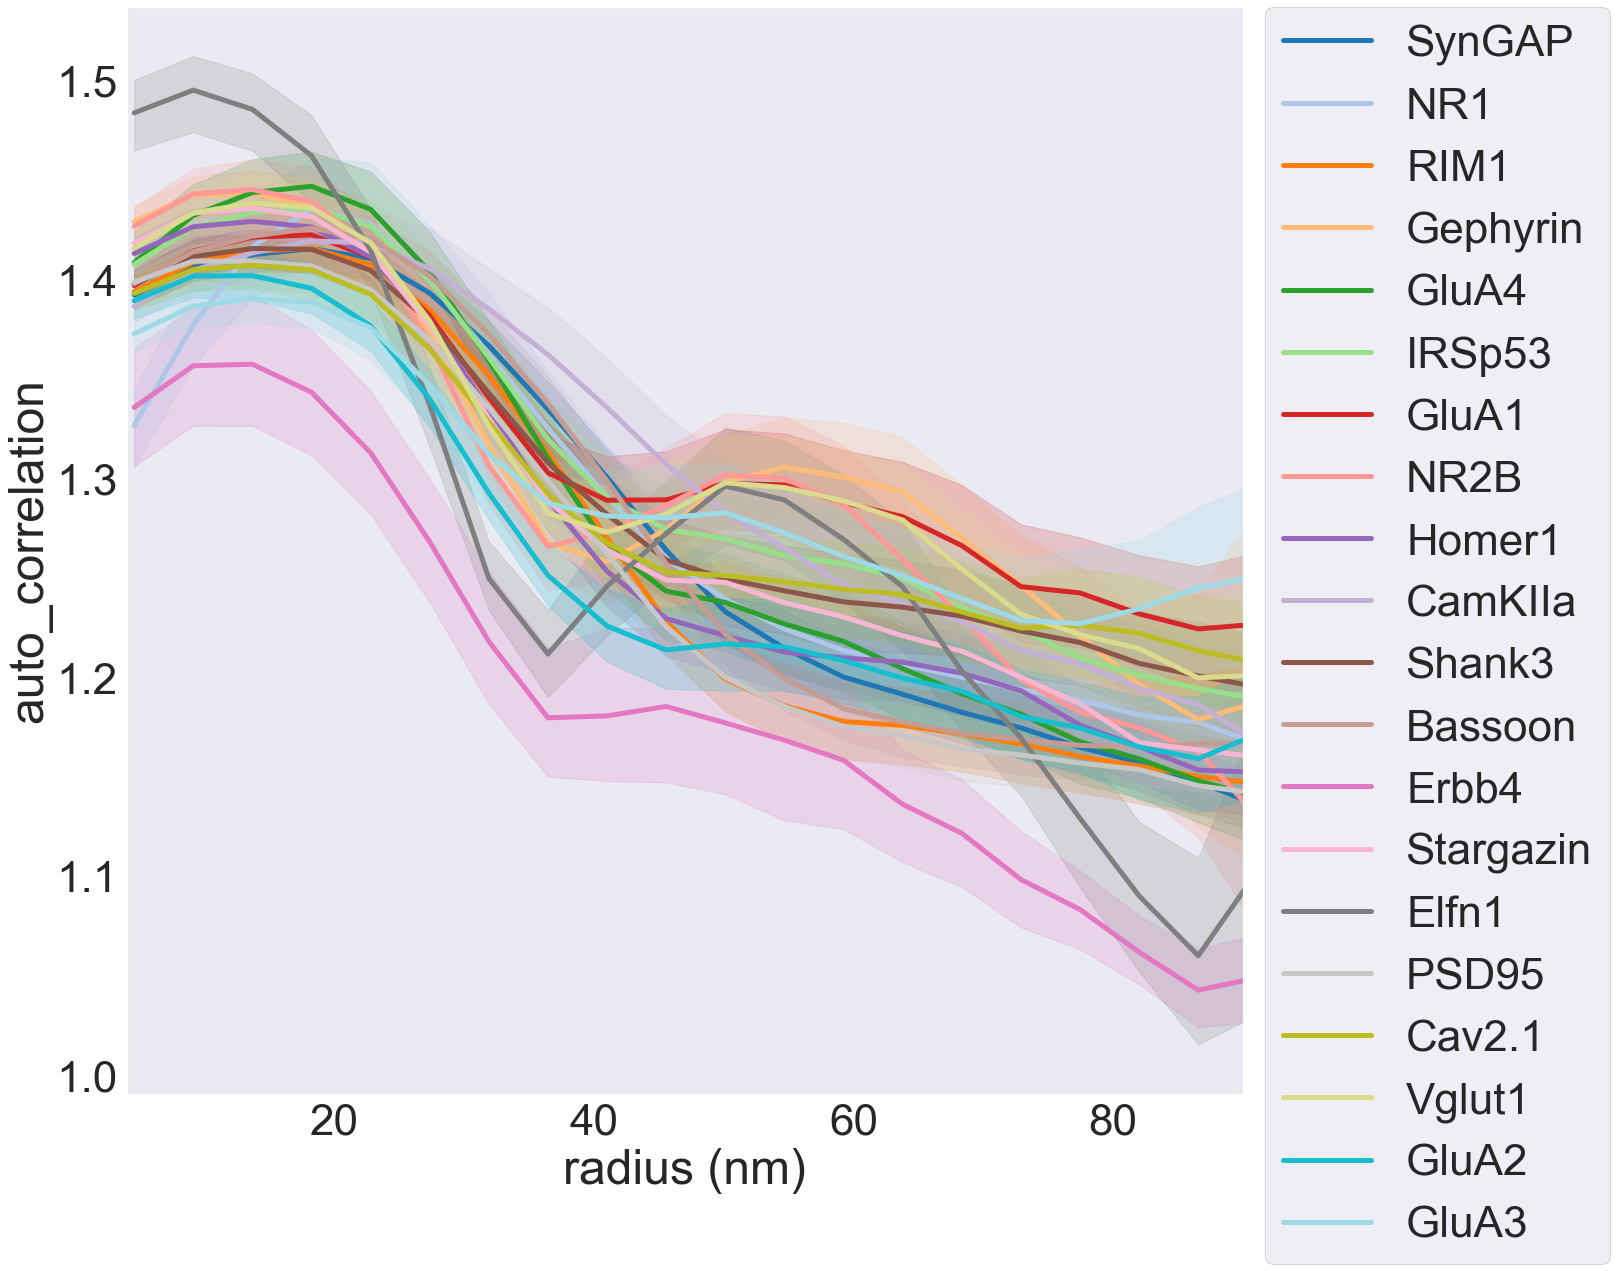

In [40]:
plt.figure(figsize=(20, 20))
sns.set(font_scale=4)
ax = sns.lineplot(data=allauto_data.reset_index(), x='radius (nm)', y='auto_correlation',
                  hue='protein', palette='tab20', legend='brief', linewidth=5)
legend = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
for line in legend.get_lines():
    line.set_linewidth(5)
ax.set_xlim(left=4, right=90)
ax.grid(False)
plt.savefig(parentdir + 'autocorrelation_curve_all_confs.png', dpi=300, transparent=False, bbox_inches='tight')

# IN PROGRESS FOR CURRENT MANUSCRIPT SUBMISSION - 3) Calculate the enrichment index

"To more easily compare the extent of the enrichment between these proteins in each layer, we also calculated the enrichment index, which is an average of all enrichment values within 60 nm (biological units) of the peak of a designated channel".\

In [52]:
unique_pairs = unique(list(alldata['pair']))

In [53]:
pair_names = []
pair_means = []
pair_sems = []
pair_counts = []

for pair in unique_pairs:
    temp = alldata[alldata['pair']==pair]
    subset = temp[temp['distance_to_protein2_peak (nm)'] <= 60].groupby('synID').mean()
    pair_mean = subset.mean()['protein1_intensity (a.u.)']
    pair_sem = subset.sem()['protein1_intensity (a.u.)']
    pair_count = subset.count()['protein1_intensity (a.u.)']
    
    pair_names.append(pair)
    pair_means.append(pair_mean)
    pair_sems.append(pair_sem)
    pair_counts.append(pair_count)

In [54]:
enrichment_index_df = pd.DataFrame(zip(pair_names,pair_means,pair_sems,pair_counts),
                                   columns=['pair_name','pair_ei_mean','pair_ei_sem','pair_ei_count'])

In [55]:
enrichment_index_df.sort_values(by='pair_name')

,pair_name,pair_ei_mean,pair_ei_sem,pair_ei_count
11,Bassoon_Bassoon,1.330157,0.007767,40
167,Bassoon_CamKIIa,1.191068,0.022908,29
87,Bassoon_Cav2.1,0.952220,0.024682,28
195,Bassoon_Elfn1,1.237929,0.021801,31
9,Bassoon_Erbb4,1.133427,0.036001,23
...,...,...,...,...
174,Vglut1_PSD95,0.932873,0.066477,5
73,Vglut1_RIM1,1.172447,0.023178,31
163,Vglut1_Shank3,1.030924,0.023412,2
157,Vglut1_SynGAP,0.937101,0.071998,6


In [56]:
os.getcwd()

'/Users/margaret/Dropbox (MIT)/mExR_analysis/Scripts/Python'

In [57]:
enrichment_index_df.to_csv(parentdir + 'enrichment_index.csv',index=False)

In [58]:
#create a matrix to paste into Excel for colormapping

prots1=[]
prots2=[]

for idx,row in enrichment_index_df.iterrows():
    #print(row)
    prot1 = row['pair_name'].split("_")[0]
    prot2 = row['pair_name'].split("_")[-1]
    prots1.append(prot1)
    prots2.append(prot2)

In [59]:
enrichment_index_df['protein1']=prots1
enrichment_index_df['protein2']=prots2

In [60]:
proteins = unique(enrichment_index_df['protein1'])

In [61]:
proteins

['Bassoon',
 'Stargazin',
 'Cav2.1',
 'Shank3',
 'RIM1',
 'GluA3',
 'GluA4',
 'IRSp53',
 'GluA1',
 'PSD95',
 'Vglut1',
 'SynGAP',
 'CamKIIa',
 'Erbb4',
 'GluA2',
 'Homer1',
 'NR1',
 'Gephyrin',
 'Elfn1',
 'NR2B']

In [62]:
enrichment_index_df

,pair_name,pair_ei_mean,pair_ei_sem,pair_ei_count,protein1,protein2
0,Homer1_SynGAP,0.924260,0.031770,21,Homer1,SynGAP
1,NR2B_Erbb4,0.997955,0.019797,3,NR2B,Erbb4
2,GluA3_GluA3,1.374177,0.012536,38,GluA3,GluA3
3,Bassoon_GluA1,1.198955,0.026702,34,Bassoon,GluA1
4,GluA2_IRSp53,0.900321,0.037547,4,GluA2,IRSp53
...,...,...,...,...,...,...
349,NR1_GluA3,1.189549,0.051860,24,NR1,GluA3
350,Cav2.1_GluA1,1.238577,0.030603,28,Cav2.1,GluA1
351,SynGAP_PSD95,0.890819,0.032611,35,SynGAP,PSD95
352,Shank3_Gephyrin,1.116140,NaN,1,Shank3,Gephyrin


In [63]:
new_pairs = []
for idx,row in enrichment_index_df.iterrows():
    pair_name = row['protein1'] + '_' + row['protein2']
    new_pairs.append(pair_name)

In [64]:
enrichment_index_df['pair_name']=new_pairs

In [65]:
proteins.sort()

In [66]:
enrichment_index_df

,pair_name,pair_ei_mean,pair_ei_sem,pair_ei_count,protein1,protein2
0,Homer1_SynGAP,0.924260,0.031770,21,Homer1,SynGAP
1,NR2B_Erbb4,0.997955,0.019797,3,NR2B,Erbb4
2,GluA3_GluA3,1.374177,0.012536,38,GluA3,GluA3
3,Bassoon_GluA1,1.198955,0.026702,34,Bassoon,GluA1
4,GluA2_IRSp53,0.900321,0.037547,4,GluA2,IRSp53
...,...,...,...,...,...,...
349,NR1_GluA3,1.189549,0.051860,24,NR1,GluA3
350,Cav2.1_GluA1,1.238577,0.030603,28,Cav2.1,GluA1
351,SynGAP_PSD95,0.890819,0.032611,35,SynGAP,PSD95
352,Shank3_Gephyrin,1.116140,NaN,1,Shank3,Gephyrin


In [67]:
unique(enrichment_index_df['protein1'])

['Bassoon',
 'Stargazin',
 'Cav2.1',
 'Shank3',
 'RIM1',
 'GluA3',
 'GluA4',
 'IRSp53',
 'GluA1',
 'PSD95',
 'Vglut1',
 'SynGAP',
 'CamKIIa',
 'Erbb4',
 'GluA2',
 'Homer1',
 'NR1',
 'Gephyrin',
 'Elfn1',
 'NR2B']

In [75]:
prepost_dict = {
    'Bassoon':'pre',
    'Cav2.1':'pre',
    'RIM1':'pre',
    'Vglut1':'pre',

    'CamKIIa':'post',
    'GluA1':'post',
    'GluA3':'post',
    'GluA2':'post',
    'GluA4':'post',
    'NR1':'post',
    'NR2B':'post',
    'PSD95':'post',
    'Shank3':'post',
    'Stargazin':'post',
    'SynGAP':'post',
    'Gephyrin':'post',
    'Elfn1':'post',
    'IRSp53':'post',
    'Homer1':'post',
    'Erbb4':'post'
    
}


In [76]:
len(prepost_dict)

20

In [77]:
#for now, restrict to pre-post pairs
preposts = []
for idx,row in enrichment_index_df.iterrows():
    prot1 = row['protein1']
    prot2 = row['protein2']
    prot1_ident = prepost_dict[prot1]
    prot2_ident = prepost_dict[prot2]
    if prot1_ident != prot2_ident:
        preposts.append(True)
    else:
        preposts.append(False)

In [78]:
enrichment_index_df['pre-post'] = preposts

In [79]:
#enrichment_index_df = enrichment_index_df[enrichment_index_df['pre-post']==True]

In [80]:
enrichment_index_df

,pair_name,pair_ei_mean,pair_ei_sem,pair_ei_count,protein1,protein2,pre-post
0,Homer1_SynGAP,0.924260,0.031770,21,Homer1,SynGAP,False
1,NR2B_Erbb4,0.997955,0.019797,3,NR2B,Erbb4,False
2,GluA3_GluA3,1.374177,0.012536,38,GluA3,GluA3,False
3,Bassoon_GluA1,1.198955,0.026702,34,Bassoon,GluA1,True
4,GluA2_IRSp53,0.900321,0.037547,4,GluA2,IRSp53,False
...,...,...,...,...,...,...,...
349,NR1_GluA3,1.189549,0.051860,24,NR1,GluA3,False
350,Cav2.1_GluA1,1.238577,0.030603,28,Cav2.1,GluA1,True
351,SynGAP_PSD95,0.890819,0.032611,35,SynGAP,PSD95,False
352,Shank3_Gephyrin,1.116140,NaN,1,Shank3,Gephyrin,False


In [81]:
proteins = unique(enrichment_index_df['protein1'])

In [82]:
enrichment_index_df['pair_name'].value_counts()

Homer1_SynGAP    1
Bassoon_NR2B     1
IRSp53_GluA4     1
NR1_Bassoon      1
GluA1_GluA3      1
                ..
Elfn1_Cav2.1     1
Cav2.1_IRSp53    1
Erbb4_Bassoon    1
Vglut1_GluA1     1
Stargazin_NR1    1
Name: pair_name, Length: 354, dtype: int64

In [83]:
enrich_matrix = np.zeros((len(proteins),len(proteins)))

In [84]:
enrichment_index_df

,pair_name,pair_ei_mean,pair_ei_sem,pair_ei_count,protein1,protein2,pre-post
0,Homer1_SynGAP,0.924260,0.031770,21,Homer1,SynGAP,False
1,NR2B_Erbb4,0.997955,0.019797,3,NR2B,Erbb4,False
2,GluA3_GluA3,1.374177,0.012536,38,GluA3,GluA3,False
3,Bassoon_GluA1,1.198955,0.026702,34,Bassoon,GluA1,True
4,GluA2_IRSp53,0.900321,0.037547,4,GluA2,IRSp53,False
...,...,...,...,...,...,...,...
349,NR1_GluA3,1.189549,0.051860,24,NR1,GluA3,False
350,Cav2.1_GluA1,1.238577,0.030603,28,Cav2.1,GluA1,True
351,SynGAP_PSD95,0.890819,0.032611,35,SynGAP,PSD95,False
352,Shank3_Gephyrin,1.116140,NaN,1,Shank3,Gephyrin,False


In [85]:
for idx1,prot1 in enumerate(proteins):
    for idx2,prot2 in enumerate(proteins):
            subset = enrichment_index_df[enrichment_index_df['pair_name']==prot1+'_'+prot2]
            if len(subset['pair_ei_mean']) > 0:
                enrich_matrix[idx1,idx2]=subset['pair_ei_mean']
            else:
                enrich_matrix[idx1,idx2]=.8

In [86]:
pd.DataFrame(enrich_matrix,columns=proteins,index=proteins).to_clipboard()

In [87]:
enrich_df = pd.DataFrame(enrich_matrix,columns=proteins,index=proteins)

In [88]:
proteins

['Bassoon',
 'Stargazin',
 'Cav2.1',
 'Shank3',
 'RIM1',
 'GluA3',
 'GluA4',
 'IRSp53',
 'GluA1',
 'PSD95',
 'Vglut1',
 'SynGAP',
 'CamKIIa',
 'Erbb4',
 'GluA2',
 'Homer1',
 'NR1',
 'Gephyrin',
 'Elfn1',
 'NR2B']

Reorder the correlation matrix using this function: https://wil.yegelwel.com/cluster-correlation-matrix/

In [89]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [90]:
plt.rcParams['figure.dpi'] = 300

<AxesSubplot:>

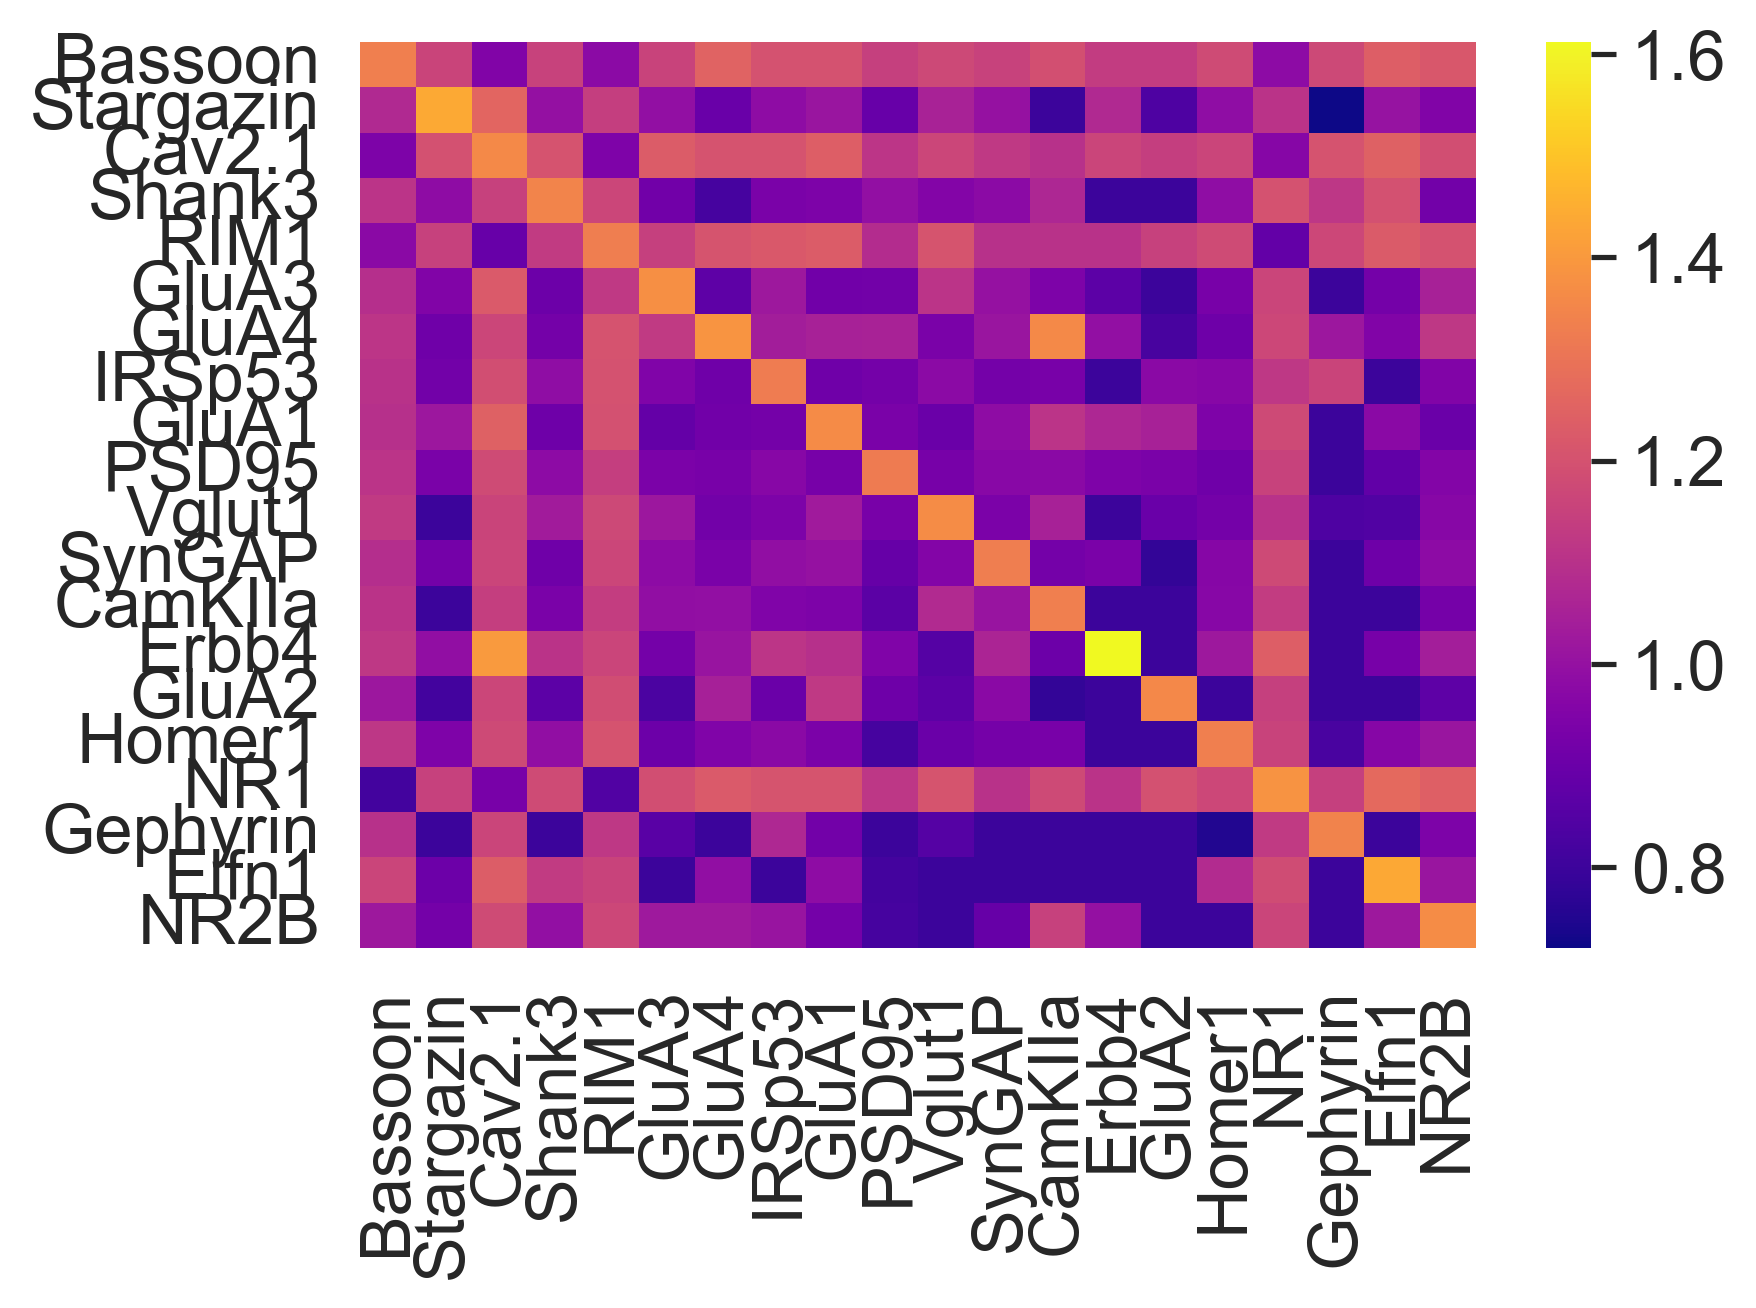

In [91]:
sns.heatmap(enrich_df,cmap='plasma',yticklabels=1,xticklabels=1)

In [92]:
reordered = cluster_corr(enrich_df)

<AxesSubplot:>

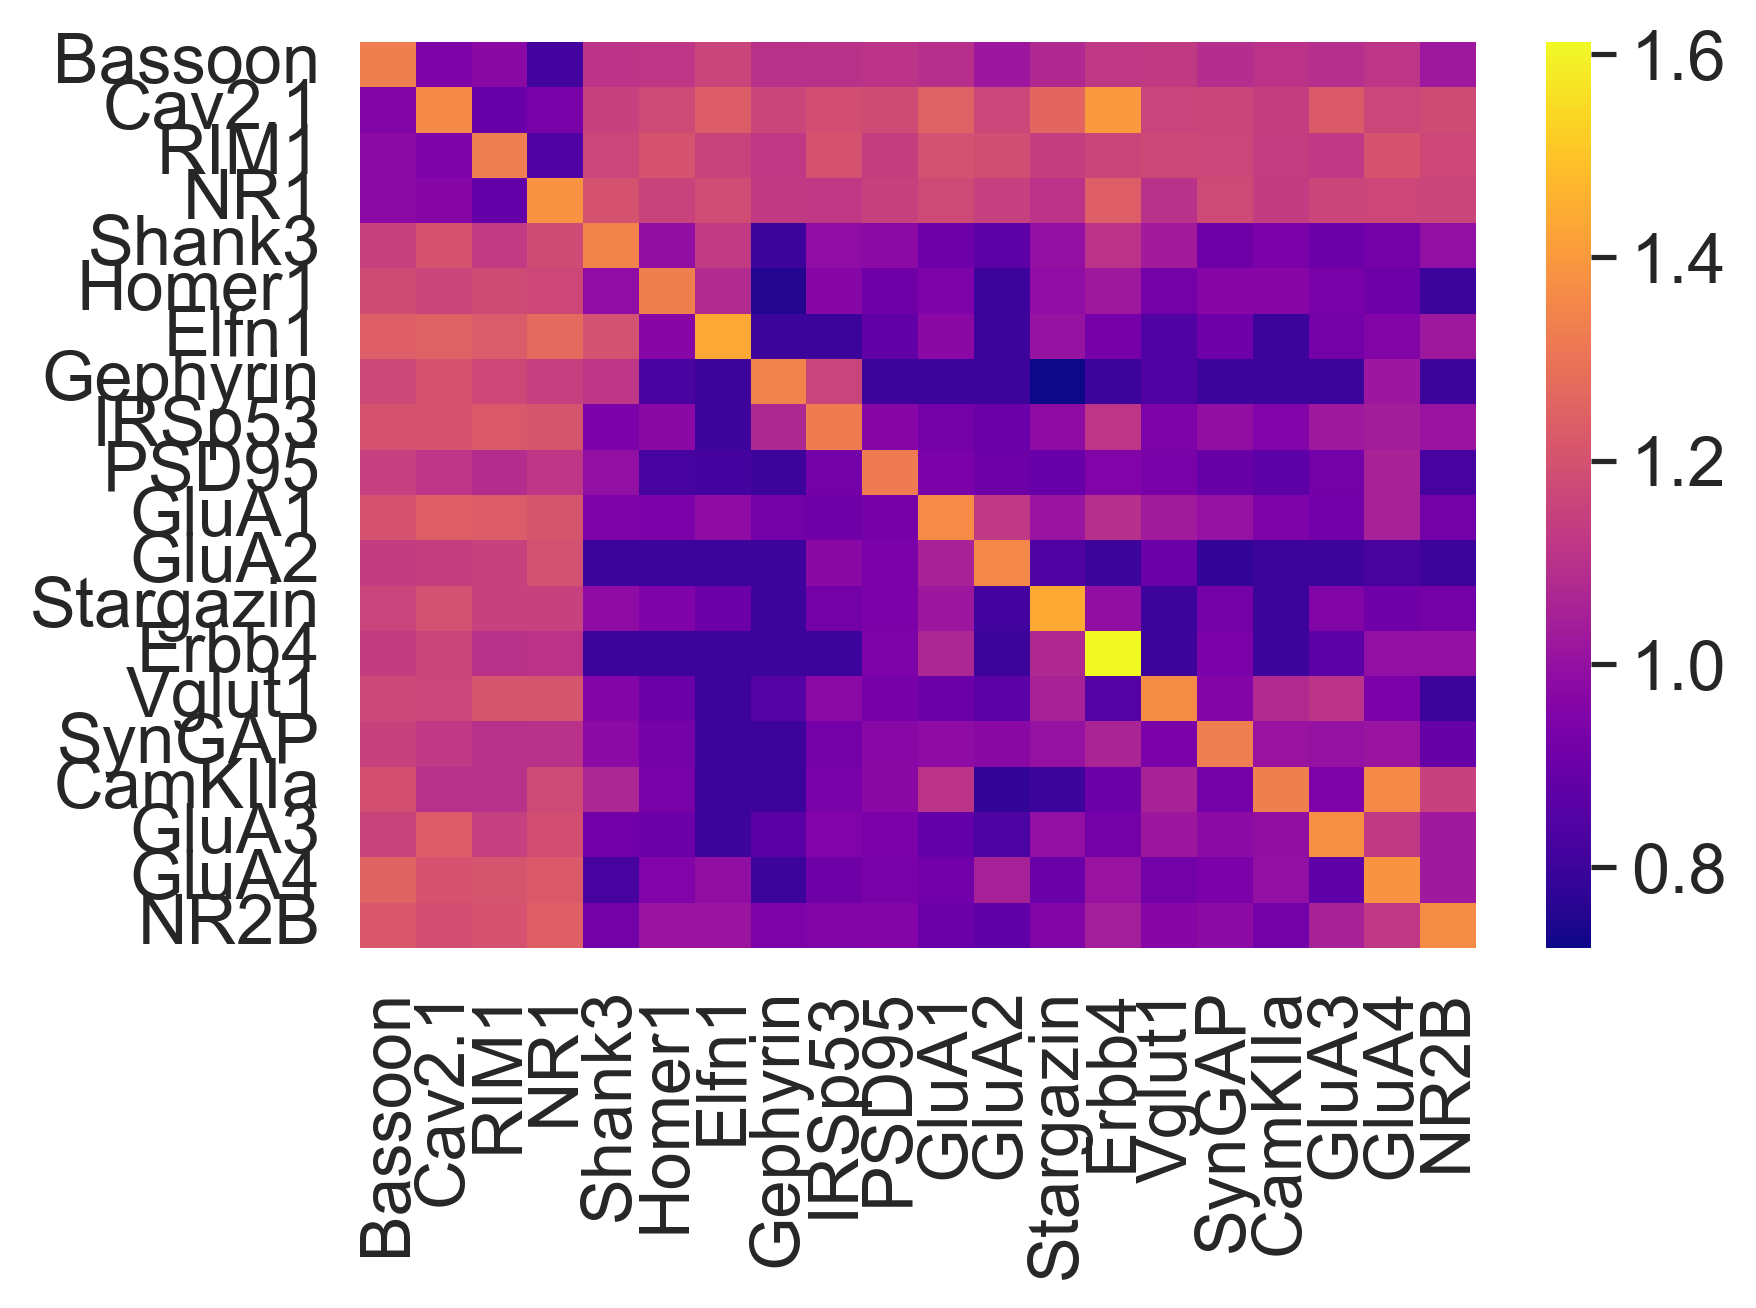

In [93]:
sns.heatmap(reordered,cmap='plasma',yticklabels=1,xticklabels=1)

In [94]:
len(unique(alldata['synID']))

40